In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt

In [136]:
#Use only the continuous variables as a feature vector
train_df = pd.read_csv("train.txt", usecols=[0,2,4,10,11,12], names=["age", "fnlwgt", "education-num", "capital-gain", "capital-loss","hours-per-week"])
train_label = pd.read_csv("train.txt", usecols=[14], names=["label"]).values
test_df = pd.read_csv("test.txt", usecols=[0,2,4,10,11,12], names=["age", "fnlwgt", "education-num", "capital-gain", "capital-loss","hours-per-week"])
#Prepocess and standardize the data 
train_features_standardized = scale(train_df.values)
test_features_standardized = scale(test_df.values)
train_labels = np.where(train_label==" >50K", 1., -1.)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [137]:
# General SVM class using stochastic gradient descent.
class SVM(object):
    def __init__(self, train=None):
        self.train = train   
    '''
    reg_con: regularization constant
    season_size: number of seasons
    step_size: number of steps in each season
    batch_size: number of samples taken from train set for each season
    heldout_size: number of samples to compute accuracy for each season
    steps_to_compute_acc: number of steps to compute accuracy
    m,n: hyper parameter to compute the learning rate
    '''
    def train_plot(self, reg_con, season_size, step_size, heldout_size, batch_size, steps_to_compute_acc, m, n):
        total_step = 0
        plot_x, plot_y, mag = [], [], []
        self.a, self.b = np.array([0. for _ in range(len(self.train[0])-1)]), 0.
        for season in range(season_size):
            #get the heldout set for computing seasonal accuracy
            np.random.shuffle(self.train)
            heldout, train = self.train[:heldout_size], self.train[heldout_size:]
            #compute the learning rate
            learning_rate = m / (0.01*season + n)
            for step in range(step_size):
                total_step += 1
                msk = np.random.randint(0, len(train), batch_size)
                batch = train[msk]
                ykx = batch[:,:-1] * batch[:,-1:]
                yk = batch[:,-1:]
                delta_a = reg_con * self.a
                delta_b = 0
                msk = (np.sum(batch[:,:-1] * self.a, axis=1).reshape(len(batch),1) + self.b) * yk >= 1
                ykx = np.where(msk, 0, ykx)
                yk = np.where(msk, 0, yk)
                delta_a -= np.mean(ykx, axis = 0)
                delta_b -= np.mean(yk)
                self.a -= learning_rate * delta_a
                self.b -= learning_rate * delta_b
                if total_step % steps_to_compute_acc == 0:
                    plot_x.append(total_step)
                    plot_y.append(self.get_acc(heldout[:,-1:], self.predict(heldout[:,:-1])))
                    mag.append(np.linalg.norm(np.concatenate((self.a, [self.b]))))
        #Generate plot
        #Should be together 
        plt.figure()
        plt.xlabel("steps")
        plt.ylabel("accuracy")
        plt.ylim(0,1)
        plt.title("regularization constant = " + str(reg_con))
        plt.plot(plot_x, plot_y)
        plt.figure()
        plt.xlabel("steps")
        plt.ylabel("coefficient magnitude")
        plt.title("regularization constant = " + str(reg_con))
        plt.plot(plot_x, mag)
        return self
    
    def predict(self, examples):
        return np.where(np.sum(examples * self.a, axis=1) + self.b >= 0, 1., -1.).reshape(len(examples),1)
    
    def get_acc(self, true_labels, predicted_labels):
        return np.sum(np.where(true_labels == predicted_labels, 1, 0)) / len(predicted_labels)
    

In [138]:
# regularization constant
regs = [1e-4,1e-3, 1e-2, 1e-1, 1]
#validation ration for searching the best regularization constant
vr = .1

# split the train data
print(len(train_features_standardized))
validation_features_standardized, validation_labels = train_features_standardized[:int(len(train_features_standardized)*vr)], train_labels[:int(len(train_features_standardized)*vr)]
train_features_standardized, train_labels = train_features_standardized[int(len(train_features_standardized)*vr):], train_labels[int(len(train_features_standardized)*vr):]
print(len(train_features_standardized), len(validation_features_standardized))

43957
39562 4395


reg_con:0.0001 0.7938566552901024
reg_con:0.001 0.7968145620022753
reg_con:0.01 0.8031854379977247
reg_con:0.1 0.7642775881683731
reg_con:1 0.7588168373151308


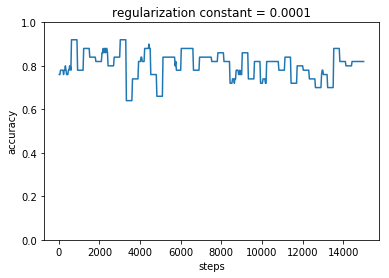

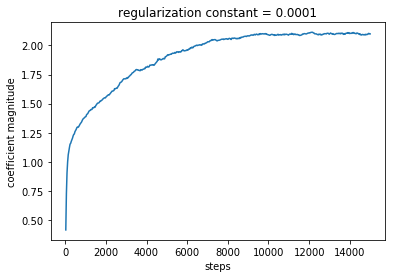

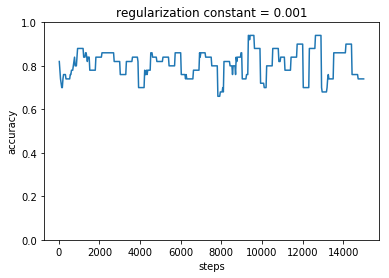

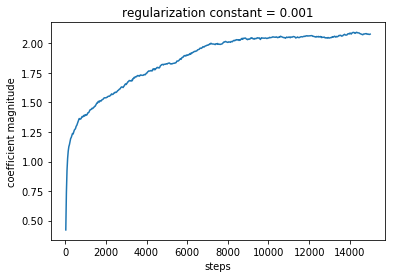

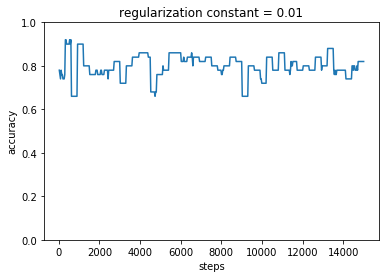

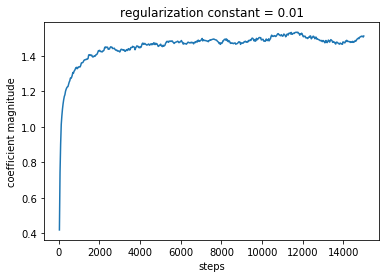

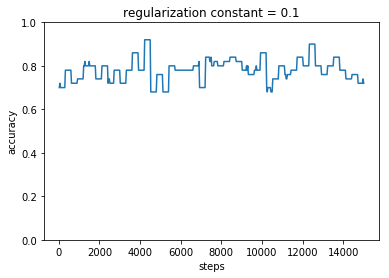

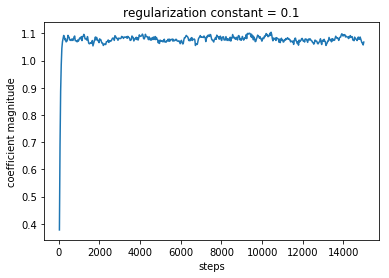

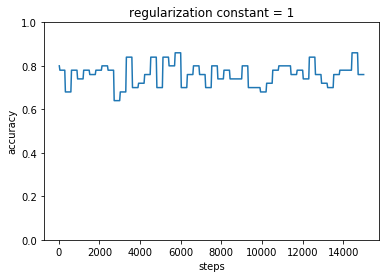

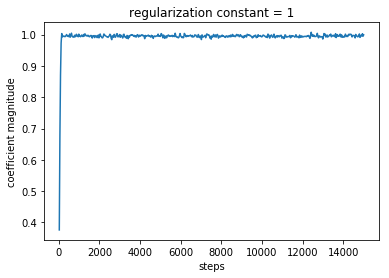

In [141]:
for reg_con in regs:
    svm = SVM(np.concatenate((train_features_standardized, train_labels),axis = 1)).train_plot(reg_con, season_size=50, step_size=300, heldout_size=50, batch_size=50, steps_to_compute_acc=30, m=1,n=50)
    # save the test result 
    if reg_con == 0.001:
        with open("submission.txt","w") as res:
            predictions = svm.predict(test_features_standardized)
            for i in predictions:
                if i == 1.:
                    res.write(">50K\n")
                else:
                    res.write("<=50K\n")
    predictions = svm.predict(validation_features_standardized)
    print("reg_con:"+str(reg_con), svm.get_acc(validation_labels, predictions))